# 손동작 분류 경진대회

## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 15)

In [9]:
df = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/손동작-분류/Data/train.csv')
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/손동작-분류/Data/test.csv')

In [11]:
df.shape, test.shape

((2335, 33), (9343, 32))

In [10]:
df.drop('id', axis=1, inplace=True) ## id 컬럼 드랍
test.drop('id', axis=1, inplace=True) ## id 컬럼 드랍

## 센서 데이터를 이미지로 변환

In [6]:
df.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,...,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000
mean,-1.122174,-1.024673,-0.672769,-0.147724,-0.327494,-0.423462,0.676275,...,-0.081374,-0.370812,-0.726941,-0.809534,-0.495062,-0.743585,1.523340
std,11.486353,7.399859,26.519159,15.551500,11.461970,7.314322,26.869479,...,25.923355,15.541803,11.636507,7.469744,25.291238,16.300385,1.118221
min,-94.746969,-63.942094,-122.195138,-111.870691,-94.147972,-70.916786,-105.956553,...,-105.751637,-105.890010,-74.977182,-74.006065,-121.097086,-123.876153,0.000000
25%,-4.036597,-4.031957,-14.878500,-7.116633,-3.968687,-3.957699,-13.937806,...,-14.096840,-8.004561,-3.981055,-3.988965,-13.998874,-7.873898,1.000000
50%,-0.951398,-1.015582,-0.961088,-0.890469,-0.871690,-0.804810,0.058910,...,-0.954791,-0.989293,-0.889780,-0.928504,-0.955684,-1.019547,2.000000
75%,2.895540,2.140456,13.974075,6.110973,2.970387,3.006144,13.934438,...,13.903783,5.922250,2.972719,2.519426,13.926128,5.121679,3.000000
max,68.876142,39.913391,127.124171,102.015561,89.059852,34.923040,120.046277,...,123.179253,111.137925,54.098746,35.896503,125.974107,104.959621,3.000000


`-` 32개의 센서피쳐는 하나의 픽셀을 의미하는 것이 아닐까?(손동작 이미지를 32개의 픽셀로 나눈 것 같다; 아님말고)

`-` 0부근에 값이 많고 변수마다 분포가 유사함(종모양) 

`-` $8\times 4$ 배열로 변환하고 이를 확인해보자($4\times 8$로 해도 상관없을 듯)

`-` 위는 각 target의 sensor_1부터 sensor_32까지 각각의 평균이다

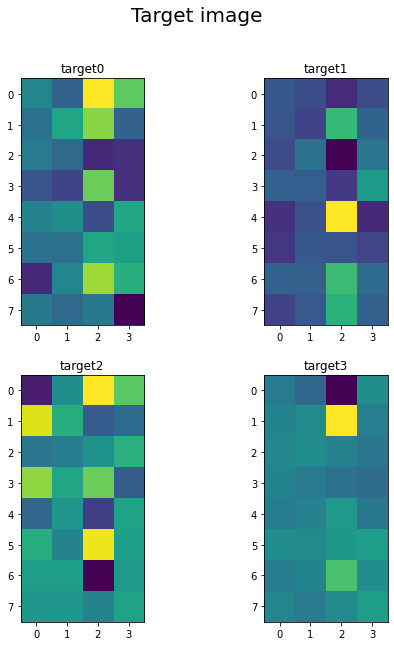

In [7]:
plt.figure(figsize=(8, 10))
for i in range(4) :
    plt.subplot(2, 2, i+1)
    plt.title(f'target{i}')
    plt.imshow(df.groupby('target').agg('mean').iloc[i,:].to_numpy().reshape(8, 4))
plt.suptitle('Target image', fontsize=20)
plt.show()

`-` 위의 4가지 그림을 보면 target마다 평균적으로 값의 차이가 있음을 알 수 있다

## CNN 설계 및 학습

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import StratifiedKFold

In [60]:
torch.manual_seed(22) ## 재현을 위한 seed 고정

`-` 일단 데이터를 정규화시켜주자(0부터 1까지)

`-` 값이 음수이면 활성화함수로 렐루를 취할 때 0이 되면서 노드가 죽어버린다(기울기 소멸)

In [13]:
target = df['target']
df.drop('target', axis=1, inplace=True)

In [46]:
X_df = (df + 130) / 260 ## 음수를 양수로 만들어주고 값을 0~1사이로 맞춰준다
X_test = (test + 130) / 260

In [47]:
X_df = torch.tensor(np.array(X_df).reshape(-1, 1, 8, 4), dtype=torch.float32) ## 1(흑백) * 8(높이) * 4(너비) 이미지가 -1(2335)개 존재함
X_test = torch.tensor(np.array(X_test).reshape(-1, 1, 8, 4), dtype=torch.float32)

In [48]:
print('min :', X_df.min(), '\nmax :', X_df.max())

min : tensor(0.0085) 
max : tensor(0.9891)


`-` 정규화가 잘 되었다

In [50]:
len(X_df)

2335

In [88]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2, 1), padding='same'), ## padding='same' 옵션을 사용할려면 stride가 1이어야 한다
            ## 흑백이미지이므로 처음 인풋 채널은 1이다
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=(2, 1), padding='same'), ## 이미지가 직사각형이라 직사각형 커널 사용
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(4, 2), padding='same'),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=(3, 2), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(3, 2), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=(3, 2), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.AdaptiveAvgPool2d(1) ## Flatten역할 ## 이미지를 평균내서 1*1 크기로 만든다
        )
        
        self.linear_model = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 4) ## softmax는 옵티마이저(CrossEntorpyLoss)에서 수행
        )

    def forward(self, x):
        x = self.cnn_model(x) ## After, shape -> (N, 16, 1, 1) 
        x = x.squeeze() ## After, shape -> (N, 16)
        x = self.linear_model(x) ## After, shape -> (N, 4)
        return x

In [89]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 1)
        nn.init.constant_(m.bias.data, 0)

In [90]:
skfold = StratifiedKFold(n_splits=15, random_state=22, shuffle=True) ## 15겹 교차검증

In [91]:
learning_rate = 0.005
epochs = 100
batch_size = 32
loss_fn = torch.nn.CrossEntropyLoss()   ## 손실 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨

In [92]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

`-` 모델 앙상블

In [93]:
cnn_acc = [] ## fold별 valid셋의 평균 정확도
cnn_pred = torch.tensor(np.zeros((X_test.shape[0], 4))) ## test예측값

for i, (train_idx, valid_idx) in tqdm(enumerate(skfold.split(X_df, target))):
    print(f'{i + 1} Fold Training......')
    X_train, y_train = X_df[train_idx], target[train_idx]
    X_valid, y_valid = X_df[valid_idx], target[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## CNN 모델
    net = CNN()
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    total_batch = len(train_dataloader) ## 배치 크기
    
    ## optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    
    ## fold별로 모델 학습
    net.train() ## 훈련모드
    for epoch in range(epochs): 
        avg_loss = 0 ## train mean loss

        for X, y in train_dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            optimizer.zero_grad() ## 그래디언트 초기화
            yhat = net(X) ## y_hat을 구한다
            loss = loss_fn(yhat, y) ## 오차를 계산 ## train loss
            loss.backward()  ## 미분
            optimizer.step() ## 업데이트
            avg_loss += (loss / total_batch) ## 평균 오차 누적

        if epoch % 20 == 0 or epoch == epochs - 1:
            print('[Epoch: {:>4}] loss = {:>.9}'.format(epoch + 1, avg_loss)) ## 에폭마다 현재 훈련 오차 출력
    
    ## fold별로 모델 평가
    net.eval() ## 평가모드
    valid_loss = [] 
    acc_list = []

    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in valid_dataloader: 
            yhat = net(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = accuracy(y.detach().cpu().numpy(), yhat.detach().cpu().numpy().argmax(-1))                                                         
            valid_loss.append(loss.cpu().numpy())
            acc_list.append(acc)
            
    cnn_acc.append(np.mean(acc_list)) ## fold별 정확도
            
    print(f'{i + 1} Fold -> Mean Valid Loss : {np.mean(valid_loss):>8f}') ## fold별 평가 루프 종료시 평균 loss를 출력
    print(f'{i + 1} Fold -> Mean Valid accuracy : {np.mean(acc_list):>8f}') ## fold별 평가 루프 종료시 accuracy를 출력
    
    ## fold별로 test 예측
    net.eval() ## 평가모드
    with torch.no_grad():
        outputs = net(X_test) ## shape -> (9343, 4)
        cnn_pred += outputs / skfold.n_splits

0it [00:00, ?it/s]

1 Fold Training......
[Epoch:    1] loss = 2.15869594
[Epoch:   21] loss = 0.424006552
[Epoch:   41] loss = 0.251804352
[Epoch:   61] loss = 0.176591977
[Epoch:   81] loss = 0.114561364
[Epoch:  100] loss = 0.110126682
1 Fold -> Mean Valid Loss : 0.068236
1 Fold -> Mean Valid accuracy : 0.971467


1it [00:58, 58.75s/it]

2 Fold Training......
[Epoch:    1] loss = 1.9950099
[Epoch:   21] loss = 0.401188642
[Epoch:   41] loss = 0.229782701
[Epoch:   61] loss = 0.131951496
[Epoch:   81] loss = 0.137745157
[Epoch:  100] loss = 0.073887594
2 Fold -> Mean Valid Loss : 0.127197
2 Fold -> Mean Valid accuracy : 0.958786


2it [01:56, 58.37s/it]

3 Fold Training......
[Epoch:    1] loss = 1.99249601
[Epoch:   21] loss = 0.388645321
[Epoch:   41] loss = 0.238821641
[Epoch:   61] loss = 0.181996584
[Epoch:   81] loss = 0.106204957
[Epoch:  100] loss = 0.10752365
3 Fold -> Mean Valid Loss : 0.060115
3 Fold -> Mean Valid accuracy : 0.980072


3it [02:56, 59.04s/it]

4 Fold Training......
[Epoch:    1] loss = 1.67914402
[Epoch:   21] loss = 0.454761684
[Epoch:   41] loss = 0.330356866
[Epoch:   61] loss = 0.209405869
[Epoch:   81] loss = 0.150803208
[Epoch:  100] loss = 0.115767837
4 Fold -> Mean Valid Loss : 0.293462
4 Fold -> Mean Valid accuracy : 0.907609


4it [03:53, 58.28s/it]

5 Fold Training......
[Epoch:    1] loss = 1.81479704
[Epoch:   21] loss = 0.434202105
[Epoch:   41] loss = 0.280167907
[Epoch:   61] loss = 0.189241409
[Epoch:   81] loss = 0.130159035
[Epoch:  100] loss = 0.102035411
5 Fold -> Mean Valid Loss : 0.233831
5 Fold -> Mean Valid accuracy : 0.925272


5it [04:50, 57.78s/it]

6 Fold Training......
[Epoch:    1] loss = 2.35469174
[Epoch:   21] loss = 0.397476107
[Epoch:   41] loss = 0.250626832
[Epoch:   61] loss = 0.183634073
[Epoch:   81] loss = 0.126272067
[Epoch:  100] loss = 0.071669288
6 Fold -> Mean Valid Loss : 0.051255
6 Fold -> Mean Valid accuracy : 0.981884


6it [05:47, 57.56s/it]

7 Fold Training......
[Epoch:    1] loss = 1.92802119
[Epoch:   21] loss = 0.37985146
[Epoch:   41] loss = 0.214130193
[Epoch:   61] loss = 0.130274549
[Epoch:   81] loss = 0.0951441154
[Epoch:  100] loss = 0.112077296
7 Fold -> Mean Valid Loss : 0.069476
7 Fold -> Mean Valid accuracy : 0.971467


7it [06:43, 57.05s/it]

8 Fold Training......
[Epoch:    1] loss = 1.7847538
[Epoch:   21] loss = 0.416910768
[Epoch:   41] loss = 0.301644176
[Epoch:   61] loss = 0.173742801
[Epoch:   81] loss = 0.0978725851
[Epoch:  100] loss = 0.116472855
8 Fold -> Mean Valid Loss : 0.096030
8 Fold -> Mean Valid accuracy : 0.965127


8it [07:43, 57.94s/it]

9 Fold Training......
[Epoch:    1] loss = 1.9704057
[Epoch:   21] loss = 0.45969075
[Epoch:   41] loss = 0.270368248
[Epoch:   61] loss = 0.178803548
[Epoch:   81] loss = 0.185436606
[Epoch:  100] loss = 0.0943489149
9 Fold -> Mean Valid Loss : 0.035140
9 Fold -> Mean Valid accuracy : 0.988678


9it [08:46, 59.45s/it]

10 Fold Training......
[Epoch:    1] loss = 1.7167232
[Epoch:   21] loss = 0.441697925
[Epoch:   41] loss = 0.278887928
[Epoch:   61] loss = 0.173484504
[Epoch:   81] loss = 0.102154218
[Epoch:  100] loss = 0.0798909888
10 Fold -> Mean Valid Loss : 0.063936
10 Fold -> Mean Valid accuracy : 0.972977


10it [09:52, 61.46s/it]

11 Fold Training......
[Epoch:    1] loss = 2.09545922
[Epoch:   21] loss = 0.426127136
[Epoch:   41] loss = 0.227760509
[Epoch:   61] loss = 0.14794901
[Epoch:   81] loss = 0.118709996
[Epoch:  100] loss = 0.127772957
11 Fold -> Mean Valid Loss : 0.408248
11 Fold -> Mean Valid accuracy : 0.887228


11it [11:05, 65.17s/it]

12 Fold Training......
[Epoch:    1] loss = 2.53746223
[Epoch:   21] loss = 0.490479887
[Epoch:   41] loss = 0.266013801
[Epoch:   61] loss = 0.231878638
[Epoch:   81] loss = 0.117690489
[Epoch:  100] loss = 0.0987436995
12 Fold -> Mean Valid Loss : 0.076302
12 Fold -> Mean Valid accuracy : 0.974638


12it [12:16, 66.69s/it]

13 Fold Training......
[Epoch:    1] loss = 1.93519032
[Epoch:   21] loss = 0.395111769
[Epoch:   41] loss = 0.219403505
[Epoch:   61] loss = 0.146826267
[Epoch:   81] loss = 0.0902135596
[Epoch:  100] loss = 0.0807329342
13 Fold -> Mean Valid Loss : 0.022014
13 Fold -> Mean Valid accuracy : 0.995471


13it [13:28, 68.49s/it]

14 Fold Training......
[Epoch:    1] loss = 2.75410843
[Epoch:   21] loss = 0.401631355
[Epoch:   41] loss = 0.27603519
[Epoch:   61] loss = 0.158221394
[Epoch:   81] loss = 0.116362669
[Epoch:  100] loss = 0.115833238
14 Fold -> Mean Valid Loss : 0.024413
14 Fold -> Mean Valid accuracy : 0.992301


14it [14:36, 68.26s/it]

15 Fold Training......
[Epoch:    1] loss = 1.8521086
[Epoch:   21] loss = 0.419041961
[Epoch:   41] loss = 0.267218202
[Epoch:   61] loss = 0.159111947
[Epoch:   81] loss = 0.151619598
[Epoch:  100] loss = 0.126291052
15 Fold -> Mean Valid Loss : 0.113421
15 Fold -> Mean Valid accuracy : 0.966486


15it [15:30, 62.04s/it]


In [72]:
cnn_acc = [] ## fold별 valid셋의 평균 정확도
cnn_pred = torch.tensor(np.zeros((X_test.shape[0], 4))) ## test예측값

for i, (train_idx, valid_idx) in tqdm(enumerate(skfold.split(X_df, target))):
    print(f'{i + 1} Fold Training......')
    X_train, y_train = X_df[train_idx], target[train_idx]
    X_valid, y_valid = X_df[valid_idx], target[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## CNN 모델
    net = CNN()
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    total_batch = len(train_dataloader) ## 배치 크기
    
    ## optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    
    ## fold별로 모델 학습
    net.train() ## 훈련모드
    for epoch in range(epochs): 
        avg_loss = 0 ## train mean loss

        for X, y in train_dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            optimizer.zero_grad() ## 그래디언트 초기화
            yhat = net(X) ## y_hat을 구한다
            loss = loss_fn(yhat, y) ## 오차를 계산 ## train loss
            loss.backward()  ## 미분
            optimizer.step() ## 업데이트
            avg_loss += (loss / total_batch) ## 평균 오차 누적

        if epoch % 20 == 0 or epoch == epochs - 1:
            print('[Epoch: {:>4}] loss = {:>.9}'.format(epoch + 1, avg_loss)) ## 에폭마다 현재 훈련 오차 출력
    
    ## fold별로 모델 평가
    net.eval() ## 평가모드
    valid_loss = [] 
    acc_list = []

    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in valid_dataloader: 
            yhat = net(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = accuracy(y.detach().cpu().numpy(), yhat.detach().cpu().numpy().argmax(-1))                                                         
            valid_loss.append(loss.cpu().numpy())
            acc_list.append(acc)
            
    cnn_acc.append(np.mean(acc_list)) ## fold별 정확도
            
    print(f'{i + 1} Fold -> Mean Valid Loss : {np.mean(valid_loss):>8f}') ## fold별 평가 루프 종료시 평균 loss를 출력
    print(f'{i + 1} Fold -> Mean Valid accuracy : {np.mean(acc_list):>8f}') ## fold별 평가 루프 종료시 accuracy를 출력
    
    ## fold별로 test 예측
    net.eval() ## 평가모드
    with torch.no_grad():
        outputs = net(X_test) ## shape -> (9343, 4)
        cnn_pred += outputs / skfold.n_splits

0it [00:00, ?it/s]

1 Fold Training......
[Epoch:    1] loss = 1.10051358
[Epoch:   21] loss = 0.223249987
[Epoch:   41] loss = 0.0922718644
[Epoch:   61] loss = 0.117340177
[Epoch:   81] loss = 0.0453387722
[Epoch:  100] loss = 0.021794714
1 Fold -> Mean Valid Loss : 0.020981
1 Fold -> Mean Valid accuracy : 0.993659


1it [00:49, 49.46s/it]

2 Fold Training......
[Epoch:    1] loss = 1.17392814
[Epoch:   21] loss = 0.252365708
[Epoch:   41] loss = 0.116710544
[Epoch:   61] loss = 0.0564955659
[Epoch:   81] loss = 0.0315789878
[Epoch:  100] loss = 0.0467428491
2 Fold -> Mean Valid Loss : 1.171700
2 Fold -> Mean Valid accuracy : 0.775362


2it [01:38, 49.29s/it]

3 Fold Training......
[Epoch:    1] loss = 1.16563857
[Epoch:   21] loss = 0.229865566
[Epoch:   41] loss = 0.184297517
[Epoch:   61] loss = 0.0787316561
[Epoch:   81] loss = 0.0624652319
[Epoch:  100] loss = 0.0458124839
3 Fold -> Mean Valid Loss : 0.177993
3 Fold -> Mean Valid accuracy : 0.927989


3it [02:29, 50.05s/it]

4 Fold Training......
[Epoch:    1] loss = 1.29755652
[Epoch:   21] loss = 0.230661452
[Epoch:   41] loss = 0.12180528
[Epoch:   61] loss = 0.067038089
[Epoch:   81] loss = 0.0429222882
[Epoch:  100] loss = 0.0550783873
4 Fold -> Mean Valid Loss : 0.058732
4 Fold -> Mean Valid accuracy : 0.979620


4it [03:19, 49.95s/it]

5 Fold Training......
[Epoch:    1] loss = 1.27536321
[Epoch:   21] loss = 0.258081198
[Epoch:   41] loss = 0.116938263
[Epoch:   61] loss = 0.0684954897
[Epoch:   81] loss = 0.0296407547
[Epoch:  100] loss = 0.0593740456
5 Fold -> Mean Valid Loss : 0.055726
5 Fold -> Mean Valid accuracy : 0.984149


5it [04:10, 50.21s/it]

6 Fold Training......
[Epoch:    1] loss = 1.20267212
[Epoch:   21] loss = 0.214390472
[Epoch:   41] loss = 0.109184414
[Epoch:   61] loss = 0.107145913
[Epoch:   81] loss = 0.0434503742
[Epoch:  100] loss = 0.0526989289
6 Fold -> Mean Valid Loss : 0.032527
6 Fold -> Mean Valid accuracy : 0.988678


6it [05:05, 51.84s/it]

7 Fold Training......
[Epoch:    1] loss = 1.20789778
[Epoch:   21] loss = 0.208147943
[Epoch:   41] loss = 0.0928229168
[Epoch:   61] loss = 0.0636091083
[Epoch:   81] loss = 0.0585144311
[Epoch:  100] loss = 0.0419949926
7 Fold -> Mean Valid Loss : 1.745016
7 Fold -> Mean Valid accuracy : 0.755888


7it [05:53, 50.67s/it]

8 Fold Training......
[Epoch:    1] loss = 1.3583498
[Epoch:   21] loss = 0.166333765
[Epoch:   41] loss = 0.097830385
[Epoch:   61] loss = 0.0522908792
[Epoch:   81] loss = 0.0648565218
[Epoch:  100] loss = 0.069615081
8 Fold -> Mean Valid Loss : 0.020280
8 Fold -> Mean Valid accuracy : 0.993659


8it [06:43, 50.36s/it]

9 Fold Training......
[Epoch:    1] loss = 1.19541252
[Epoch:   21] loss = 0.216289654
[Epoch:   41] loss = 0.0853321701
[Epoch:   61] loss = 0.0824637711
[Epoch:   81] loss = 0.070773825
[Epoch:  100] loss = 0.0525862314
9 Fold -> Mean Valid Loss : 0.763534
9 Fold -> Mean Valid accuracy : 0.817633


9it [07:34, 50.69s/it]

10 Fold Training......
[Epoch:    1] loss = 1.22113359
[Epoch:   21] loss = 0.190957457
[Epoch:   41] loss = 0.120721966
[Epoch:   61] loss = 0.0863023028
[Epoch:   81] loss = 0.0464561917
[Epoch:  100] loss = 0.0387136005
10 Fold -> Mean Valid Loss : 0.119613
10 Fold -> Mean Valid accuracy : 0.956975


10it [08:38, 54.77s/it]

11 Fold Training......
[Epoch:    1] loss = 1.34486914
[Epoch:   21] loss = 0.262805343
[Epoch:   41] loss = 0.0948042795
[Epoch:   61] loss = 0.0647485331
[Epoch:   81] loss = 0.0420575142
[Epoch:  100] loss = 0.0710336566
11 Fold -> Mean Valid Loss : 0.060428
11 Fold -> Mean Valid accuracy : 0.975996


11it [09:31, 54.36s/it]

12 Fold Training......
[Epoch:    1] loss = 1.36971498
[Epoch:   21] loss = 0.281120747
[Epoch:   41] loss = 0.152324677
[Epoch:   61] loss = 0.098904863
[Epoch:   81] loss = 0.0544994734
[Epoch:  100] loss = 0.0822492614
12 Fold -> Mean Valid Loss : 0.071704
12 Fold -> Mean Valid accuracy : 0.971920


12it [10:20, 52.78s/it]

13 Fold Training......
[Epoch:    1] loss = 1.25195181
[Epoch:   21] loss = 0.238601282
[Epoch:   41] loss = 0.163281858
[Epoch:   61] loss = 0.0898292288
[Epoch:   81] loss = 0.0710017383
[Epoch:  100] loss = 0.0219975375
13 Fold -> Mean Valid Loss : 0.002483
13 Fold -> Mean Valid accuracy : 1.000000


13it [11:09, 51.54s/it]

14 Fold Training......
[Epoch:    1] loss = 1.30532718
[Epoch:   21] loss = 0.224212632
[Epoch:   41] loss = 0.110390209
[Epoch:   61] loss = 0.0451067574
[Epoch:   81] loss = 0.0599729121
[Epoch:  100] loss = 0.0571893677
14 Fold -> Mean Valid Loss : 0.017025
14 Fold -> Mean Valid accuracy : 0.994565


14it [11:59, 51.10s/it]

15 Fold Training......
[Epoch:    1] loss = 1.29976344
[Epoch:   21] loss = 0.231570661
[Epoch:   41] loss = 0.156360418
[Epoch:   61] loss = 0.030473927
[Epoch:   81] loss = 0.0564520396
[Epoch:  100] loss = 0.0265852027
15 Fold -> Mean Valid Loss : 0.117527
15 Fold -> Mean Valid accuracy : 0.961051


15it [13:01, 52.10s/it]


In [76]:
print('평균 정확도:', np.mean(cnn_acc))

평균 정확도: 0.9384762479871175


In [94]:
print('평균 정확도:', np.mean(cnn_acc))

평균 정확도: 0.9626308373590983


In [79]:
cnn_pred.shape

torch.Size([9343, 4])

`-` softmax function을 취하면 4개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [95]:
_, pred = torch.max(cnn_pred, dim=1) ## 최대값과 인덱스를 반환
## return (value, indices), 1차원을 기준으로 max를 구한다
## 1차원을 기준으로 max를 구하므로 1차원을 없앤 9343개의 max가 반환된다
## 행별로 4개의 값 중 최대값을 리턴(총 9343개)
## 만약 dim=0으로 했다면 0번째 열~4번째 열별로 최대값을 구하므로 총 4개의 max값이 리턴됨

In [96]:
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/손동작-분류/Data/sample_submission.csv')

In [97]:
submission['target'] = pred
submission.head()

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2


In [98]:
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/손동작-분류/Data/submission2_15fold.csv', index=False)